In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.monitors import Monitor
from bindsnet.network.topology import Connection
from bindsnet.learning import PostPre
from bindsnet.learning import Hebbian
from tqdm import tqdm
from sklearn.metrics import f1_score
import time
from bindsnet.analysis.plotting import plot_spikes
from bindsnet.encoding import PoissonEncoder
from bindsnet.network.monitors import Monitor

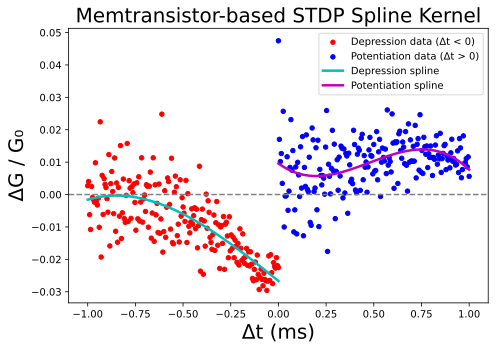

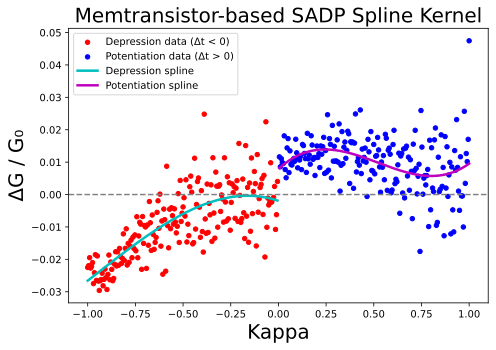

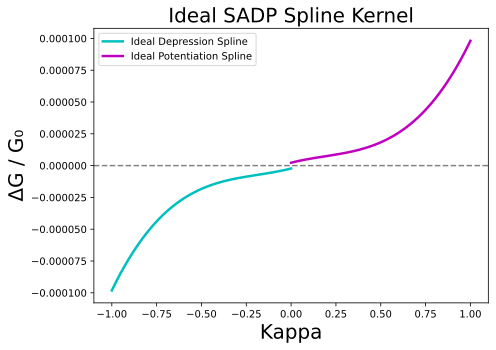

In [2]:
%run SADP_functions.ipynb

In [3]:
# Parameters
n_hidden = 400
time_window = 10  # ms
stdp_epochs = 10    # Number of epochs for STDP training
batch_size = 64
num_classes = 10

# --- Build Network ---
net = Network()

input_layer = Input(n=784, traces=True)
hidden_layer = LIFNodes(n=n_hidden, traces=True)

# Initial weights
w = 0.3 * torch.rand(784, n_hidden)

# Hebbian connection
connection = Connection(
    source=input_layer,
    target=hidden_layer,
    w=w,
    update_rule=None,  # <--- Use Hebbian here
    nu=1e-4,               # <--- Learning rate (symmetric)
    wmin=0.0,
    wmax=1.0,
)

# Add layers and connection
net.add_layer(input_layer, name='Input')
net.add_layer(hidden_layer, name='Hidden')
net.add_connection(connection, source='Input', target='Hidden')

# Monitor hidden spikes
spike_monitor = Monitor(obj=hidden_layer, state_vars=['s'], time=time_window)
net.add_monitor(monitor=spike_monitor, name='spikes')

# --- Custom Rate Encoder ---
class RateEncoder:
    def __init__(self, time):
        self.time = time

    def __call__(self, data):
        if not isinstance(data, torch.Tensor):
            data = torch.from_numpy(np.array(data))
        data = data.float() / 255.0
        data = data.view(-1)  # Flatten to 784
        return data.unsqueeze(0).repeat(self.time, 1)
    
encoder = RateEncoder(time=time_window)

# --- Feature Extraction ---

def extract_features(dataset, net, encoder, monitor, time, n_samples, learning=False):
    features = []
    labels = []

    net.learning = learning
    progress_bar = tqdm(enumerate(dataset), total=n_samples, desc="Extracting features", unit="sample")
    
    for i, (image, label) in progress_bar:
        if i >= n_samples:
            break

        encoded = encoder(image)  # [time, 784]
        monitor.reset_state_variables()
        net.reset_state_variables()

        net.run(inputs={'Input': encoded}, time=time)

        spikes = monitor.get('s').squeeze(1)  # [time, n_hidden]
        spike_counts = spikes.sum(dim=0).numpy()
        features.append(spike_counts)
        labels.append(label)

        # --- Improved Hebbian Update ---
        if learning:
            input_spikes = encoded.float()  # [time, 784]
            hidden_spikes = spikes.float()  # [time, n_hidden]
            
            # STDP-like update (simplified)
            # Δw = η * (pre_spike * post_spike - decay * w)
            hebbian_update = torch.einsum('ti,tj->ij', input_spikes, hidden_spikes)
            
            conn = net.connections[('Input', 'Hidden')]
            
            # Apply update with weight decay (Oja's rule-like normalization)
            conn.w += 1e-3 * (hebbian_update - 0.01 * conn.w)
            
            # Hard bounds
            conn.w.clamp_(min=conn.wmin, max=conn.wmax)

    return np.stack(features), np.array(labels)

dataset='fmnist'

if dataset!= 'mnist':
    # Load FMNIST dataset
    train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=None)
    test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=None)
    
else:
    # Load dataset
    train_dataset = MNIST(root='./data', train=True, download=True, transform=None)
    test_dataset = MNIST(root='./data', train=False, download=True, transform=None)

# Use full datasets
n_train = len(train_dataset)
n_test = len(test_dataset)

# --- STDP Training ---
print(f"\nStarting Hebbian training for {stdp_epochs} epochs...")
start_time = time.time()

total_time=0

for epoch in range(stdp_epochs):
    epoch_start = time.time()
    print(f"\nHebbian Epoch {epoch+1}/{stdp_epochs}")
    
    # Enable learning for STDP phase
    net.learning = True
    train_features, train_labels = extract_features(
        train_dataset, net, encoder, spike_monitor, time_window, n_train, learning=True
    )
    
    # Print weight statistics
    weights = net.connections[('Input', 'Hidden')].w
    print(f"  Weight stats - Min: {weights.min():.4f}, Max: {weights.max():.4f}, Mean: {weights.mean():.4f}")
    
    epoch_time = time.time() - epoch_start
    total_time=total_time + epoch_time
    print(f"  Epoch time: {epoch_time:.2f}s")


Starting Hebbian training for 10 epochs...

Hebbian Epoch 1/10


Extracting features: 100%|██████████████████████████████████████████████████| 60000/60000 [06:50<00:00, 146.21sample/s]


  Weight stats - Min: 0.0010, Max: 1.0000, Mean: 0.9475
  Epoch time: 410.55s

Hebbian Epoch 2/10


Extracting features:  58%|█████████████████████████████                     | 34832/60000 [04:04<02:46, 151.35sample/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Extracting features: 100%|██████████████████████████████████████████████████| 60000/60000 [06:41<00:00, 149.39sample/s]


  Weight stats - Min: 0.0007, Max: 1.0000, Mean: 0.9579
  Epoch time: 401.83s

Hebbian Epoch 4/10


Extracting features: 100%|██████████████████████████████████████████████████| 60000/60000 [06:35<00:00, 151.55sample/s]


  Weight stats - Min: 0.0006, Max: 1.0000, Mean: 0.9590
  Epoch time: 396.12s

Hebbian Epoch 5/10


Extracting features: 100%|██████████████████████████████████████████████████| 60000/60000 [06:32<00:00, 152.69sample/s]


  Weight stats - Min: 0.0006, Max: 1.0000, Mean: 0.9596
  Epoch time: 393.14s

Hebbian Epoch 6/10


Extracting features: 100%|██████████████████████████████████████████████████| 60000/60000 [06:43<00:00, 148.69sample/s]


  Weight stats - Min: 0.0006, Max: 1.0000, Mean: 0.9599
  Epoch time: 403.70s

Hebbian Epoch 7/10


Extracting features: 100%|██████████████████████████████████████████████████| 60000/60000 [06:48<00:00, 146.76sample/s]


  Weight stats - Min: 0.0006, Max: 1.0000, Mean: 0.9600
  Epoch time: 409.02s

Hebbian Epoch 8/10


Extracting features:  76%|█████████████████████████████████████▊            | 45349/60000 [05:06<01:41, 144.35sample/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Extracting features: 100%|██████████████████████████████████████████████████| 60000/60000 [06:45<00:00, 147.99sample/s]


  Weight stats - Min: 0.0006, Max: 1.0000, Mean: 0.9601
  Epoch time: 405.61s

Hebbian Epoch 9/10


Extracting features: 100%|██████████████████████████████████████████████████| 60000/60000 [06:50<00:00, 146.17sample/s]


  Weight stats - Min: 0.0006, Max: 1.0000, Mean: 0.9602
  Epoch time: 410.67s

Hebbian Epoch 10/10


Extracting features: 100%|██████████████████████████████████████████████████| 60000/60000 [06:38<00:00, 150.39sample/s]


  Weight stats - Min: 0.0006, Max: 1.0000, Mean: 0.9602
  Epoch time: 399.17s


In [4]:
# --- Feature Extraction ---
print("\nExtracting final features...")
# Disable learning for feature extraction
net.learning = False
train_features, train_labels = extract_features(
    train_dataset, net, encoder, spike_monitor, time_window, n_train, learning=False
)
test_features, test_labels = extract_features(
    test_dataset, net, encoder, spike_monitor, time_window, n_test, learning=False
)


Extracting final features...


Extracting features: 100%|██████████████████████████████████████████████████| 10000/10000 [00:42<00:00, 235.36sample/s]


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, f1_score

In [6]:
y_train_oh = to_categorical(train_labels, num_classes)
y_test_oh = to_categorical(test_labels, num_classes)

# --- Build classifier ---
model = Sequential([
    Input(shape=(400,)),  # 400-dimensional input from SNN features
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# --- Compile model ---
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train model ---
model.fit(train_features, y_train_oh, epochs=100, batch_size=64, validation_split=0.1, verbose=2)

# --- Evaluate model ---
y_pred_prob = model.predict(test_features)
y_pred = np.argmax(y_pred_prob, axis=1)

# --- Compute metrics ---
acc = accuracy_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred, average='macro')

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Macro F1 Score: {f1:.4f}")


Epoch 1/100
844/844 - 3s - loss: 2.3233 - accuracy: 0.0995 - val_loss: 2.3025 - val_accuracy: 0.0942 - 3s/epoch - 4ms/step
Epoch 2/100
844/844 - 2s - loss: 2.3027 - accuracy: 0.0980 - val_loss: 2.3028 - val_accuracy: 0.0925 - 2s/epoch - 3ms/step
Epoch 3/100
844/844 - 2s - loss: 2.3027 - accuracy: 0.0971 - val_loss: 2.3027 - val_accuracy: 0.0925 - 2s/epoch - 2ms/step
Epoch 4/100
844/844 - 2s - loss: 2.3027 - accuracy: 0.0986 - val_loss: 2.3027 - val_accuracy: 0.1055 - 2s/epoch - 2ms/step
Epoch 5/100
844/844 - 2s - loss: 2.3027 - accuracy: 0.0990 - val_loss: 2.3029 - val_accuracy: 0.0942 - 2s/epoch - 2ms/step
Epoch 6/100
844/844 - 2s - loss: 2.3027 - accuracy: 0.0988 - val_loss: 2.3026 - val_accuracy: 0.1027 - 2s/epoch - 2ms/step
Epoch 7/100
844/844 - 2s - loss: 2.3027 - accuracy: 0.0993 - val_loss: 2.3028 - val_accuracy: 0.0973 - 2s/epoch - 2ms/step
Epoch 8/100
844/844 - 2s - loss: 2.3027 - accuracy: 0.0975 - val_loss: 2.3030 - val_accuracy: 0.0985 - 2s/epoch - 2ms/step
Epoch 9/100
844/

In [7]:
# Extract only serializable fields for CSV
csv_row = {'Model': 'Hebbian', 'Coding': 'rate', 'Timesteps': 10, 'Model': '1layer', 'Accuracy': acc,'F1': f1, 'Runtime_sec': total_time}

In [8]:
import csv
csv_file = "snn_benchmarking_experiment_results_hebbian_"+dataset+".csv"
# Append to CSV immediately
with open(csv_file, mode='a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=csv_row.keys())
    writer.writerow(csv_row)